In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import astropy
from astropy.io import ascii
from astropy import units
from astropy.coordinates import SkyCoord
from cmd_utilities import inpoly
import seaborn as sns
sns.set_style("whitegrid")
from sklearn import mixture
from scipy.stats import norm

In [2]:
# load data
des_walker = pd.read_csv("data/DES-Walker.csv",index_col=0)
poly = pd.read_csv("CMD_cut_ours.csv",header=None).rename(columns={0:"x",1:"y"})
df_bes = pd.read_csv("data/1545029094.511467.resu.txt",comment="#",delim_whitespace=True)
df_bes["V-I_Walker"] = df_bes["V-I"] - des_walker["V_(DES-Walker)"]["mean"]
df_bes["V_Walker"] = df_bes["V"] - des_walker["V-I_(DES-Walker)"]["mean"]
display(df_bes.columns)

Index(['Dist', 'Mv', 'CL', 'Typ', 'LTef', 'logg', 'Age', 'Mass', 'B-V', 'U-B',
       'V-I', 'V-K', 'V', 'mux', 'muy', 'Vr', 'UU', 'VV', 'WW', '[Fe/H]',
       'a(deg)', 'd(deg)', 'Av', 'Mbol', 'V-I_Walker', 'V_Walker'],
      dtype='object')

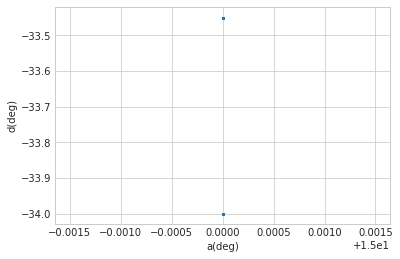

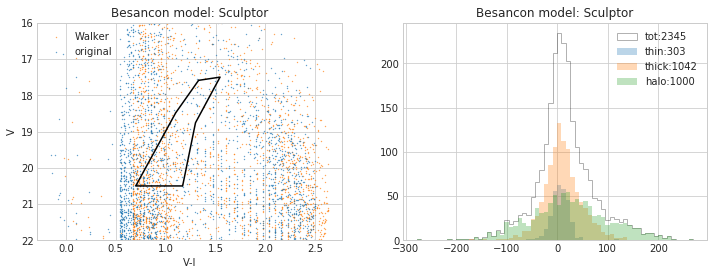

In [3]:
# Becanson model
df_bes.plot.scatter("a(deg)","d(deg)",s=1)
plt.show()

fig,axes = plt.subplots(1,2,figsize=(12,4))
df_bes.plot.scatter("V-I_Walker","V_Walker",s=0.1,ax=axes[0],label="Walker",c="C1")
df_bes.plot.scatter("V-I","V",s=0.1,ax=axes[0],label="original",c="C0")

axes[0].legend()
axes[0].set_ylim(22,16)
axes[0].set_title("Besancon model: Sculptor")
axes[0].plot(poly.x,poly.y,c="black")
#plt.show()
bins = np.linspace(df_bes.Vr.min(),df_bes.Vr.max(),64)
df_bes_halo  = df_bes[(-99 < df_bes["[Fe/H]"]) & (df_bes["[Fe/H]"] <= -1.0)]
df_bes_thick = df_bes[(-1.0 < df_bes["[Fe/H]"]) & (df_bes["[Fe/H]"] <= -0.1)]
df_bes_thin  = df_bes[(-0.1 < df_bes["[Fe/H]"]) & (df_bes["[Fe/H]"] <= +99)]
df_bes.Vr.hist(histtype='step',bins=bins,alpha=0.3,color="black",ax=axes[1])
df_bes_thin.Vr.hist(bins=bins,alpha=0.3,color="C0",ax=axes[1])
df_bes_thick.Vr.hist(bins=bins,alpha=0.3,color="C1",ax=axes[1])
df_bes_halo.Vr.hist(bins=bins,alpha=0.3,color="C2",ax=axes[1])
axes[1].legend([
    "tot:{}".format(len(df_bes)),
    "thin:{}".format(len(df_bes_thin)),
    "thick:{}".format(len(df_bes_thick)),
    "halo:{}".format(len(df_bes_halo))])
axes[1].set_title("Besancon model: Sculptor")
plt.show()

#df_bes["a(deg)"]

[[ 1.33007335  1.1002445   0.7         1.17        1.29894503  1.54514172
   1.33007335]
 [17.58606557 18.48360656 20.5        20.5        18.75688752 17.49749545
  17.58606557]]
[[ 1.1002445   0.7         1.17        1.29894503  1.54514172  1.33007335
   1.33007335]
 [18.48360656 20.5        20.5        18.75688752 17.49749545 17.58606557
  17.58606557]]


array([False, False, False, ..., False, False, False])

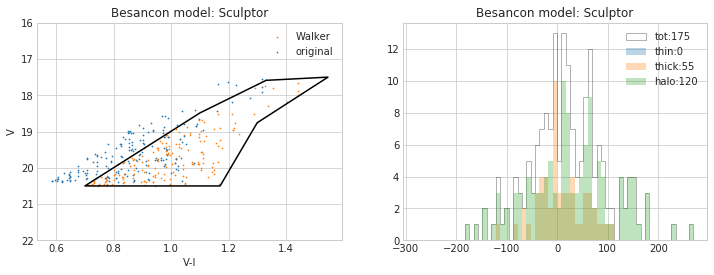

In [4]:
# Becanson model
fig,axes = plt.subplots(1,2,figsize=(12,4))
isinpoly = inpoly(xs_vertex=poly.x.values,ys_vertex=poly.y.values,x=df_bes["V-I_Walker"].values,y=df_bes["V_Walker"].values)
display(isinpoly)
df_bes[isinpoly].plot.scatter("V-I_Walker","V_Walker",s=0.5,ax=axes[0],label="Walker",c="C1")
df_bes[isinpoly].plot.scatter("V-I","V",s=0.5,ax=axes[0],label="original",c="C0")

axes[0].legend()
axes[0].set_ylim(22,16)
axes[0].set_title("Besancon model: Sculptor")
axes[0].plot(poly.x,poly.y,c="black")
#plt.show()
bins = np.linspace(df_bes.Vr.min(),df_bes.Vr.max(),64)
df_bes_halo  = df_bes[isinpoly & (-99 < df_bes["[Fe/H]"]) & (df_bes["[Fe/H]"] <= -1.0)]
df_bes_thick = df_bes[isinpoly & (-1.0 < df_bes["[Fe/H]"]) & (df_bes["[Fe/H]"] <= -0.1)]
df_bes_thin  = df_bes[isinpoly & (-0.1 < df_bes["[Fe/H]"]) & (df_bes["[Fe/H]"] <= +99)]
df_bes[isinpoly].Vr.hist(histtype='step',bins=bins,alpha=0.3,color="black",ax=axes[1])
df_bes_thin.Vr.hist(bins=bins,alpha=0.3,color="C0",ax=axes[1])
df_bes_thick.Vr.hist(bins=bins,alpha=0.3,color="C1",ax=axes[1])
df_bes_halo.Vr.hist(bins=bins,alpha=0.3,color="C2",ax=axes[1])
axes[1].legend([
    "tot:{}".format(len(df_bes[isinpoly])),
    "thin:{}".format(len(df_bes_thin)),
    "thick:{}".format(len(df_bes_thick)),
    "halo:{}".format(len(df_bes_halo))])
axes[1].set_title("Besancon model: Sculptor")
plt.show()

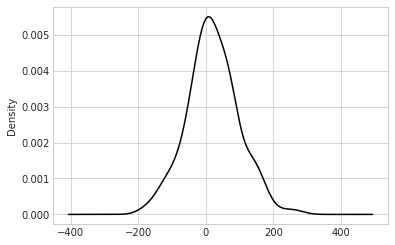

In [5]:
df_bes[isinpoly].Vr.plot.kde(color="black")

(22, 12)

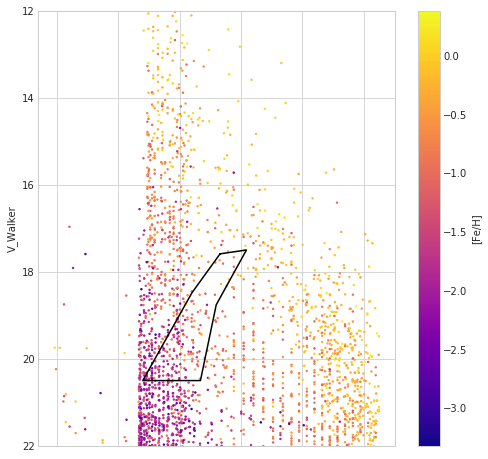

In [6]:
import matplotlib.cm as cm
df_bes.plot.scatter(x="V-I_Walker",y="V_Walker",c="[Fe/H]",s=2,cmap="plasma",figsize=(8,8))
plt.plot(poly.x,poly.y,c="black")
plt.ylim(22,12)

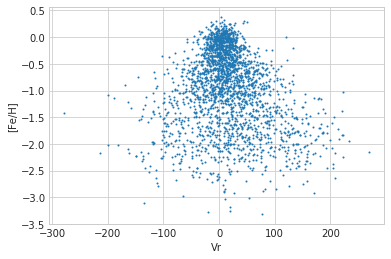

In [7]:
df_bes.columns
df_bes.plot.scatter("Vr","[Fe/H]",s=1)

# besancon 2

In [8]:
bes2 = pd.read_csv("data/bes201902041217.txt",delim_whitespace=True)
bes2.columns

Index(['V', 'B-V', 'U-B', 'V-I', 'V-K', 'mux', 'muy', 'HRV', 'UU', 'VV', 'WW',
       'Px', 'Mv', 'CL', 'Typ', 'Teff', 'logg', 'Pop', 'Age', 'Mass', 'Mbol',
       'Radius', '[M/H]', '[a/Fe]', 'longitude', 'latitude', 'RAJ2000',
       'DECJ2000', 'Dist', 'x_Gal', 'y_Gal', 'z_Gal', 'Av', 'errPx', 'errMux',
       'errMuy', 'errHrv', 'errMv', 'errMass', 'errAge', 'errTeff', 'errLogg',
       'errMet', 'errAlphaFe', 'errBand_V', 'errBand_B', 'errBand_U',
       'errBand_I', 'errBand_K'],
      dtype='object')

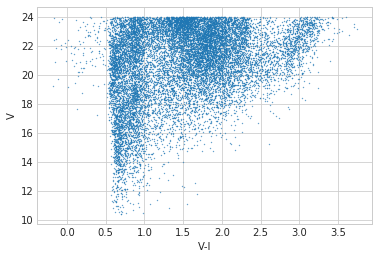

In [9]:
bes2.plot.scatter("V-I","V",s=0.1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb7af299e8>]],
      dtype=object)

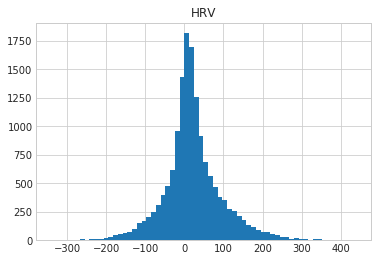

In [10]:
bes2.hist("HRV",bins=64)

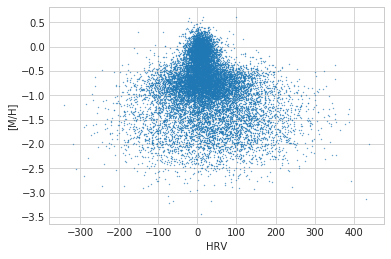

In [11]:
bes2.plot.scatter("HRV","[M/H]",s=0.1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb78d25828>],
      dtype=object)

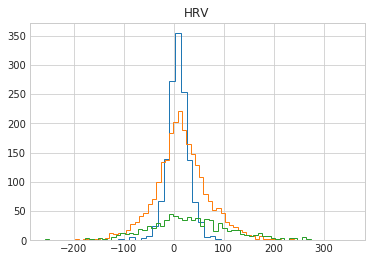

In [12]:
fig,ax = plt.subplots(1,1)
bes2_ = bes2[bes2.V < 20]
bes2_[-0.3<bes2_["[M/H]"]].hist("HRV",bins=6*4,ax=ax,color="C0",histtype="step")
bes2_[(-1.0<bes2_["[M/H]"]) & (bes2_["[M/H]"]<-0.3)].hist("HRV",bins=64,ax=ax,color="C1",histtype="step")
bes2_[bes2_["[M/H]"]<-1.0].hist("HRV",bins=64,ax=ax,color="C2",histtype="step")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb78c9c940>],
      dtype=object)

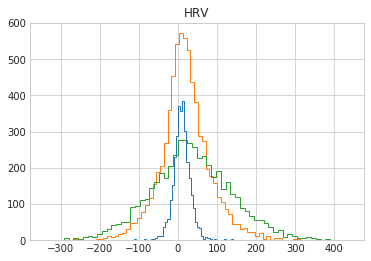

In [13]:
fig,ax = plt.subplots(1,1)
bes2[-0.3<bes2["[M/H]"]].hist("HRV",bins=64,ax=ax,color="C0",histtype="step")
bes2[(-1.0<bes2["[M/H]"]) & (bes2["[M/H]"]<-0.3)].hist("HRV",bins=64,ax=ax,color="C1",histtype="step")
bes2[bes2["[M/H]"]<-1.0].hist("HRV",bins=64,ax=ax,color="C2",histtype="step")

In [14]:
len(bes2)

15219

In [15]:
isinpoly2 = inpoly(xs_vertex=poly.x.values,ys_vertex=poly.y.values,x=bes2["V-I"].values,y=bes2["V"].values)


[[ 1.33007335  1.1002445   0.7         1.17        1.29894503  1.54514172
   1.33007335]
 [17.58606557 18.48360656 20.5        20.5        18.75688752 17.49749545
  17.58606557]]
[[ 1.1002445   0.7         1.17        1.29894503  1.54514172  1.33007335
   1.33007335]
 [18.48360656 20.5        20.5        18.75688752 17.49749545 17.58606557
  17.58606557]]


ValueError: Item wrong length 2345 instead of 15219.

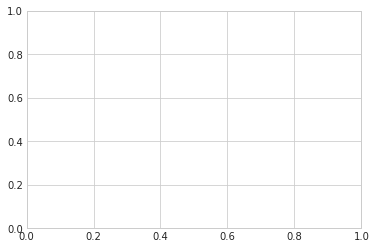

In [16]:
fig,ax = plt.subplots(1,1)
bes2_ = bes2[isinpoly]
bes2_[-0.3<bes2_["[M/H]"]].hist("HRV",bins=64,ax=ax,color="C0",histtype="step")
bes2_[(-1.0<bes2_["[M/H]"]) & (bes2_["[M/H]"]<-0.3)].hist("HRV",bins=64,ax=ax,color="C1",histtype="step")
bes2_[bes2_["[M/H]"]<-1.0].hist("HRV",bins=64,ax=ax,color="C2",histtype="step")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb78a23470>]],
      dtype=object)

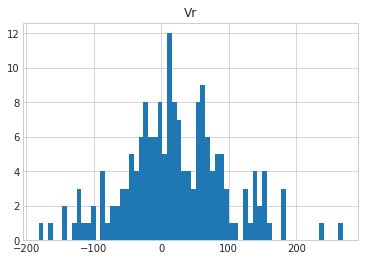

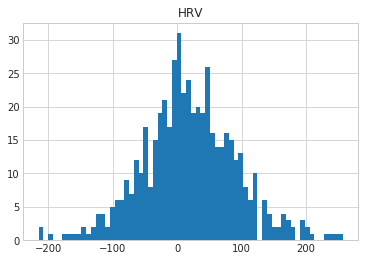

In [17]:
df_bes[isinpoly].hist("Vr",bins=64)
bes2[isinpoly2].hist("HRV",bins=64)

# Variantional Bayesian method

In [18]:
%%time
# variant Baysian estimation
data = df_bes.Vr.values.reshape(-1,1)

ress_dpgmm = []

from multiprocessing import Pool
from time import sleep

def run(i):
#define model
    np.random.seed(seed=np.random.randint(0,2**12)+np.random.randint(0,2**12)*i)
    sleep(np.random.rand()/1000)
    dpgmm = mixture.BayesianGaussianMixture(
        n_components=3,
        weight_concentration_prior=1e+2,
        init_params="random",
        max_iter=10000,tol=1e-6)
    dpgmm.fit(data)

    # store data
    res_dpgmm = pd.DataFrame()
    res_dpgmm["weights_"] = dpgmm.weights_
    res_dpgmm["means_"] = dpgmm.means_
    res_dpgmm["covariances_"] = dpgmm.covariances_.reshape(-1)
    res_dpgmm["stds_"] = np.sqrt(res_dpgmm.covariances_)
    res_dpgmm = res_dpgmm.sort_values("weights_",ascending=False).reset_index(drop=True)
    print(i)
    display(res_dpgmm)
    return res_dpgmm
    #display(res_dpgmm)
    
with Pool(processes=8) as pool:
    ret = pool.map(run, range(500))
#ret = [run(i) for i in range(10)]

48


,weights_,means_,covariances_,stds_
0,0.472974,24.750098,6310.638361,79.439526
1,0.313048,6.392143,335.733307,18.323027
2,0.213978,10.871542,1365.625707,36.954373


80


,weights_,means_,covariances_,stds_
0,0.472974,24.750101,6310.636992,79.439518
1,0.313050,6.392153,335.734982,18.323072
2,0.213976,10.871563,1365.635335,36.954504


64
32


,weights_,means_,covariances_,stds_
0,0.473084,24.750721,6308.389059,79.425368
1,0.315501,6.403899,337.787849,18.379006
2,0.211414,10.897349,1376.757672,37.104685


,weights_,means_,covariances_,stds_
0,0.464262,25.082389,6350.730990,79.691474
1,0.340475,6.575700,357.339974,18.903438
2,0.195263,10.973586,1572.391722,39.653395


112


,weights_,means_,covariances_,stds_
0,0.540192,23.608415,5850.364008,76.487672
1,0.459183,7.109258,481.083746,21.933621
2,0.000625,15.835624,3437.967044,58.634180


0


,weights_,means_,covariances_,stds_
0,0.543116,23.545798,5829.648226,76.352133
1,0.456260,7.092277,476.905077,21.838156
2,0.000625,15.830060,3435.290981,58.611355


16


,weights_,means_,covariances_,stds_
0,0.540192,23.608427,5850.368019,76.487698
1,0.459183,7.109262,481.084659,21.933642
2,0.000625,15.835581,3437.964019,58.634154


65


,weights_,means_,covariances_,stds_
0,0.480376,24.556556,6253.112770,79.076626
1,0.324116,6.414182,346.298828,18.609106
2,0.195508,11.057442,1372.198131,37.043193


96


,weights_,means_,covariances_,stds_
0,0.464279,25.081792,6350.618064,79.690765
1,0.340477,6.575607,357.345616,18.903587
2,0.195244,10.973955,1572.257511,39.651702


81


,weights_,means_,covariances_,stds_
0,0.480433,24.550272,6253.912472,79.081682
1,0.322025,6.401921,344.586546,18.563042
2,0.197542,11.039703,1361.192350,36.894340


49


,weights_,means_,covariances_,stds_
0,0.543116,23.545801,5829.649187,76.352139
1,0.456260,7.092278,476.905290,21.838161
2,0.000625,15.830046,3435.289755,58.611345


1


,weights_,means_,covariances_,stds_
0,0.543116,23.545801,5829.649157,76.352139
1,0.456260,7.092278,476.905284,21.838161
2,0.000625,15.830047,3435.289813,58.611345


113


,weights_,means_,covariances_,stds_
0,0.473085,24.750695,6308.389035,79.425368
1,0.315496,6.403867,337.783450,18.378886
2,0.211419,10.897306,1376.726794,37.104269


97


,weights_,means_,covariances_,stds_
0,0.464261,25.082415,6350.731214,79.691475
1,0.340478,6.575718,357.342189,18.903497
2,0.195261,10.973581,1572.412192,39.653653


33


,weights_,means_,covariances_,stds_
0,0.473085,24.750695,6308.387324,79.425357
1,0.315498,6.403875,337.784959,18.378927
2,0.211417,10.897324,1376.734963,37.104379


17


,weights_,means_,covariances_,stds_
0,0.464278,25.081813,6350.627143,79.690822
1,0.340474,6.575594,357.342664,18.903509
2,0.195248,10.973931,1572.245633,39.651553


66


,weights_,means_,covariances_,stds_
0,0.543231,23.543101,5828.732175,76.346134
1,0.456145,7.091337,476.682805,21.833067
2,0.000624,15.830720,3435.267037,58.611151


Process ForkPoolWorker-6:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):


KeyboardInterrupt: 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9584bae80>,
      dtype=object)

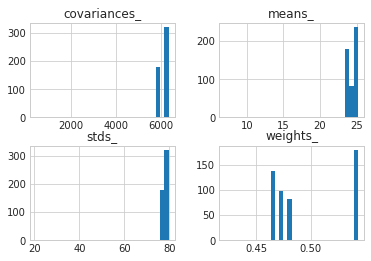

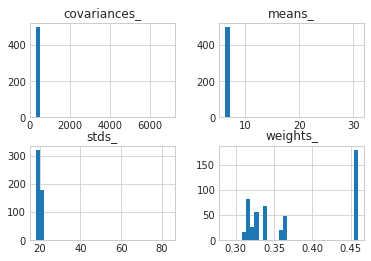

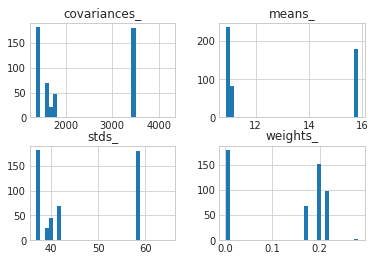

In [8]:
pd.concat(ret).iloc[0::3].hist(bins=32)
pd.concat(ret).iloc[1::3].hist(bins=32)
pd.concat(ret).iloc[2::3].hist(bins=32)

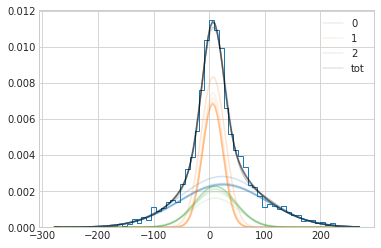

In [9]:
bins=np.linspace(df_bes.Vr.min(),df_bes.Vr.max(),64)
x=np.linspace(df_bes.Vr.min(),df_bes.Vr.max(),128)
df_bes.Vr.hist(bins=bins,histtype="step",density=True)
ytot = np.zeros(len(x))
for j in range(10):
    c = ["C0","C1","C2"]
    ytot = 0
    for i in range(3):
        res = ret[j].iloc[i]
        y = res.weights_*norm.pdf(x=x,loc=res.means_,scale=res.stds_)
        plt.plot(x,y,label=i,color=c[i],alpha=0.1)
        ytot += y
    plt.plot(x,ytot,label="tot",c="black",alpha=0.1)
    if not j:
        plt.legend()
    
#plt.legend()

In [10]:
# variant Baysian estimation for cut data
data = df_bes[isinpoly].Vr.values.reshape(-1,1)
data
dpgmm = mixture.BayesianGaussianMixture(
    n_components=3,
    weight_concentration_prior=1e+5,
    init_params="kmeans",
    max_iter=1000,tol=1e-12,)
dpgmm.fit(data)
display(dpgmm)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=1000, mean_precision_prior=None, mean_prior=None,
            n_components=3, n_init=1, random_state=None, reg_covar=1e-06,
            tol=1e-12, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=100000.0,
            weight_concentration_prior_type='dirichlet_process')

In [11]:
res_dpgmm = pd.DataFrame()
res_dpgmm["weights_"] = dpgmm.weights_
res_dpgmm["means_"] = dpgmm.means_
res_dpgmm["covariances_"] = dpgmm.covariances_.reshape(-1)
res_dpgmm["stds_"] = np.sqrt(res_dpgmm.covariances_)
display(res_dpgmm)

,weights_,means_,covariances_,stds_
0,0.290345,12.839907,1903.793782,43.632485
1,0.701221,24.936590,7313.700095,85.520174
2,0.008433,21.203120,5820.643546,76.293142


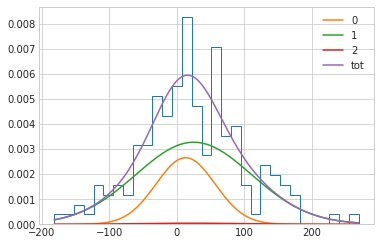

In [12]:
bins=np.linspace(df_bes[isinpoly].Vr.min(),df_bes[isinpoly].Vr.max(),32)
x=np.linspace(df_bes[isinpoly].Vr.min(),df_bes[isinpoly].Vr.max(),128)
df_bes[isinpoly].Vr.hist(bins=bins,histtype="step",density=True)
ytot = np.zeros(len(x))
for i in range(3):
    res = res_dpgmm.iloc[i]
    y = res.weights_*norm.pdf(x=x,loc=res.means_,scale=res.stds_)
    plt.plot(x,y,label=i)
    ytot += y
plt.plot(x,ytot,label="tot")  
plt.legend()

# MCMC

In [13]:
# MCMC
from scipy.stats import norm

def loglikeli_cont_(vs,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1,beta=1):
    # domain
    if dvfg0<0 or dvfg1<0 or dvfg2<0:
        return -np.inf
    sfg2 = 1-sfg0-sfg1
    if (not 0<=sfg0<=1) or (not 0<=sfg1<=1) or (not 0<=sfg2<=1) or (not sfg0>=sfg1>=sfg2):
        return -np.inf
    
    ffg0 = sfg0 * norm.pdf(vs,loc=vfg0,scale=dvfg0)
    ffg1 = sfg1 * norm.pdf(vs,loc=vfg1,scale=dvfg1)
    ffg2 = sfg2 * norm.pdf(vs,loc=vfg2,scale=dvfg2)
    ffg = ffg0+ffg1+ffg2
            
    ret = np.log(ffg)

    return beta * ret.sum()

## Full fit

In [14]:
def lnl_cont(args):
    return loglikeli_cont_(df_bes.Vr.values,*args)

In [15]:
#lnl_cont = generate_loglikeli_cont(df_bes.Vr.values)
nwalkers = 40
dim = 8

sampler = emcee.EnsembleSampler(lnpostfn=lnl_cont,nwalkers=nwalkers,dim=dim,threads=8)

In [16]:
lows = [-200,-200,-200,0,0,0,0,0]
highs = [200,200,200,400,400,400,1,1]
#lows = [lows for i in range(nwalkers)]
#highs = [highs for i in range(nwalkers)]
#pos0 = np.random.uniform(low=lows,high=highs)
#s0,s1 = np.max(pos0[:,6:],axis=1),np.min(pos0[:,6:],axis=1) 
#pos0[:,6],pos0[:,7] = s0,s1
pos0 = []
for i in range(10000):
    p0 = np.random.uniform(low=lows,high=highs)
    if lnl_cont(p0)==-np.inf:
        if i==10000-1:
            print("cannot find pos0...")
        continue
    
    pos0.append(p0)
    
    if len(pos0)==nwalkers:
        pos0 = np.array(pos0)
        break

display([lnl_cont(p0) for p0 in pos0])

[-15233.430303438488,
 -15707.296855117402,
 -15271.336661133735,
 -16584.20041808104,
 -16220.322187768368,
 -16007.617283918591,
 -15329.058502037287,
 -14387.965318710725,
 -15504.121151188257,
 -14512.90295464339,
 -15440.194761922034,
 -15964.289259181043,
 -14909.037621534417,
 -15495.848931772674,
 -14755.242748806657,
 -14945.589887024322,
 -14916.026683477789,
 -15003.287834356692,
 -14780.118576714047,
 -15649.176615965338,
 -14032.35958869951,
 -15731.590427910789,
 -14644.36187521517,
 -15685.468762475124,
 -15736.326813090658,
 -15454.840515907683,
 -13659.142969006996,
 -14941.098843657146,
 -14982.918415140684,
 -16059.428310613655,
 -14744.206277175093,
 -15432.162029233592,
 -15431.469554382173,
 -14945.87077453534,
 -15080.56382530733,
 -15468.278503980622,
 -14363.42112340957,
 -17310.811263257026,
 -15407.934207389475,
 -15407.7437900544]

In [17]:
pos, prob, state = sampler.run_mcmc(N=100,pos0=pos0)

In [18]:
%%time
for i in range(10):
    pos, prob, state = sampler.run_mcmc(N=100,pos0=pos)
    sampler.reset()

CPU times: user 3.01 s, sys: 295 ms, total: 3.31 s
Wall time: 7.42 s


In [19]:
%%time
pos,prob,state = sampler.run_mcmc(N=10000,pos0=pos)

CPU times: user 29 s, sys: 3.03 s, total: 32 s
Wall time: 1min 4s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd942ffd588>,
      dtype=object)

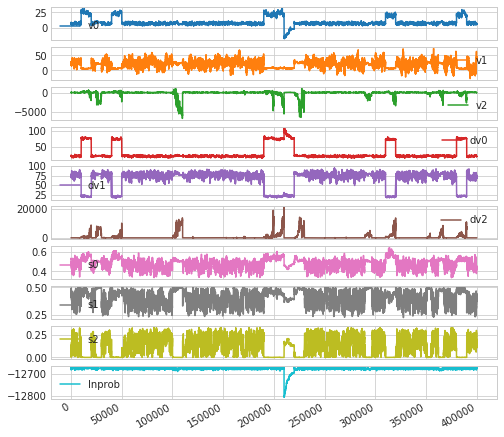

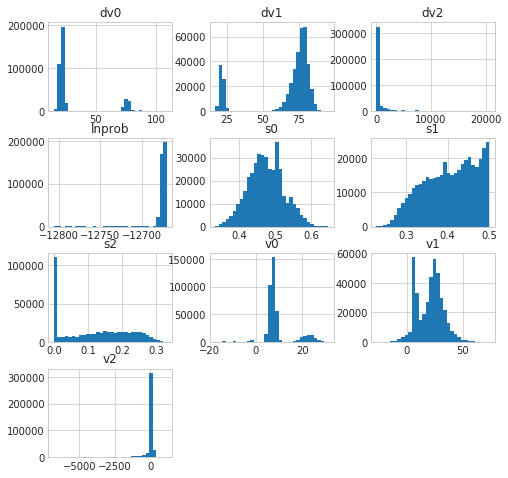

In [46]:
df_res = pd.DataFrame(sampler.flatchain)
df_res = df_res.rename(columns={0:"v0",1:"v1",2:"v2",3:"dv0",4:"dv1",5:"dv2",6:"s0",7:"s1"})
df_res["s2"] = 1-df_res.s0-df_res.s1
df_res["lnprob"] = sampler.flatlnprobability
df_res.plot(subplots=True,figsize=(8,8))
df_res.hist(bins=32,figsize=(8,8))

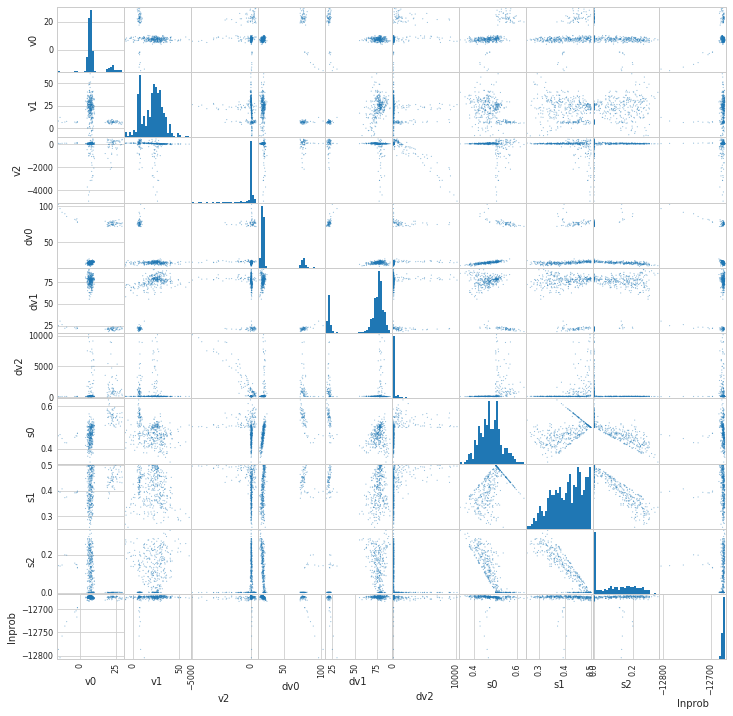

In [45]:
pd.plotting.scatter_matrix(df_res[::1000],figsize=(12,12),hist_kwds={"bins":32},s=5)
plt.show()

In [47]:
df_res.describe(percentiles=[norm.cdf(i) for i in [-2,-1,0,1,2]]) 

,v0,v1,v2,dv0,dv1,dv2,s0,s1,s2,lnprob
count,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,4.000000e+05,400000.000000
mean,9.240324,20.507604,-161.400007,31.594933,66.628200,761.764342,0.474854,0.405252,1.198937e-01,-12675.548319
std,6.335992,11.602959,744.499808,21.164480,21.245416,1985.420914,0.048782,0.062469,9.801642e-02,10.049710
min,-17.509292,-27.130803,-6768.837284,15.539188,17.115690,0.173876,0.334763,0.228686,1.829977e-08,-12806.389550
2.3%,-1.598639,-0.679507,-2754.056911,18.804166,20.156176,40.760629,0.378728,0.283700,3.809168e-05,-12696.446737
15.9%,6.082420,6.869100,-61.300589,20.512201,23.594453,58.390086,0.425912,0.332535,5.081647e-04,-12676.569006
50%,7.496691,22.321188,19.114774,22.406768,75.530114,74.850295,0.473323,0.411078,1.241109e-01,-12673.898031
84.1%,9.928499,31.380267,75.030086,73.089874,80.485288,939.812798,0.521247,0.476399,2.352197e-01,-12672.191963
97.7%,25.510193,43.531263,305.207546,79.572376,84.962213,7919.882595,0.573460,0.497172,2.877101e-01,-12671.102136
max,31.146759,73.272514,1138.303415,108.462141,95.140494,20655.953032,0.645736,0.499883,3.321270e-01,-12669.583411


In [33]:
x = np.linspace(df_bes.Vr.min(),df_bes.Vr.max(),256)
g0 = df_res.s0[:,np.newaxis]*norm.pdf(x=x[np.newaxis,:],loc=df_res.v0.values[:,np.newaxis],scale=df_res.dv0.values[:,np.newaxis])
g1 = df_res.s1[:,np.newaxis]*norm.pdf(x=x[np.newaxis,:],loc=df_res.v1.values[:,np.newaxis],scale=df_res.dv1.values[:,np.newaxis])
g2 = df_res.s2[:,np.newaxis]*norm.pdf(x=x[np.newaxis,:],loc=df_res.v2.values[:,np.newaxis],scale=df_res.dv2.values[:,np.newaxis])
gtot = g0+g1+g2

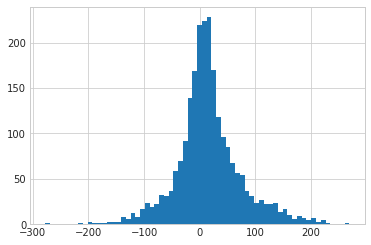

In [34]:
plt.hist(df_bes.Vr,bins=64)
plt.show()

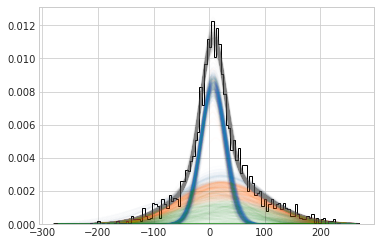

In [35]:
plt.hist(df_bes.Vr,bins=128,histtype="step",density=True,color="black")
[plt.plot(x,g,c="C2",alpha=0.01) for g in g2[::1000]]
[plt.plot(x,g,c="C1",alpha=0.01) for g in g1[::1000]]
[plt.plot(x,g,c="C0",alpha=0.01) for g in g0[::1000]]
[plt.plot(x,g,c="grey",alpha=0.01) for g in gtot[::1000]]
plt.show()

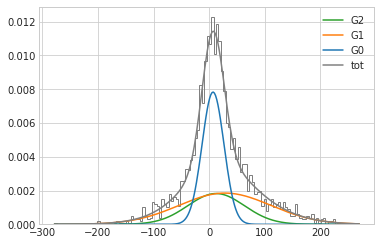

In [39]:
alpha = 1
plt.hist(df_bes.Vr,bins=128,histtype="step",density=True,color="grey",alpha=alpha)
plt.plot(x,g2[df_res.lnprob.idxmax()],c="C2",alpha=alpha,label="G2")
plt.plot(x,g1[df_res.lnprob.idxmax()],c="C1",alpha=alpha,label="G1")
plt.plot(x,g0[df_res.lnprob.idxmax()],c="C0",alpha=alpha,label="G0")
plt.plot(x,gtot[df_res.lnprob.idxmax()],c="grey",alpha=alpha,label="tot")
plt.legend()
plt.show()

In [63]:
#df_res.to_csv("result/Becanson_full.csv",index=None)

## cut fit

In [57]:
def lnl_cont_cut(args):
    return loglikeli_cont_(df_bes.Vr[isinpoly].values,*args)

In [58]:
#lnl_cont = generate_loglikeli_cont(df_bes.Vr.values)
nwalkers = 40
dim = 8

sampler_cut = emcee.EnsembleSampler(lnpostfn=lnl_cont_cut,nwalkers=nwalkers,dim=dim,threads=8)

In [59]:
lows = [-200,-200,-200,0,0,0,0,0]
highs = [200,200,200,400,400,400,1,1]
#lows = [lows for i in range(nwalkers)]
#highs = [highs for i in range(nwalkers)]
#pos0 = np.random.uniform(low=lows,high=highs)
#s0,s1 = np.max(pos0[:,6:],axis=1),np.min(pos0[:,6:],axis=1) 
#pos0[:,6],pos0[:,7] = s0,s1
pos0 = []
for i in range(10000):
    p0 = np.random.uniform(low=lows,high=highs)
    if lnl_cont_cut(p0)==-np.inf:
        if i==10000-1:
            print("cannot find pos0...")
        continue
    
    pos0.append(p0)
    
    if len(pos0)==nwalkers:
        pos0 = np.array(pos0)
        print("OK!")
        break

#display([lnl_cont(p0) for p0 in pos0])

OK!


In [60]:
pos_cut, prob_cut, state_cut = sampler_cut.run_mcmc(N=100,pos0=pos0)

In [64]:
%%time
for i in range(10):
    pos_cut, prob_cut, state_cut = sampler_cut.run_mcmc(N=100,pos0=pos_cut)
    sampler_cut.reset()

CPU times: user 3 s, sys: 354 ms, total: 3.35 s
Wall time: 5.54 s


In [65]:
%%time
pos_cut,prob_cut,state_cut = sampler_cut.run_mcmc(N=10000,pos0=pos)

CPU times: user 30.4 s, sys: 3.25 s, total: 33.7 s
Wall time: 53.4 s


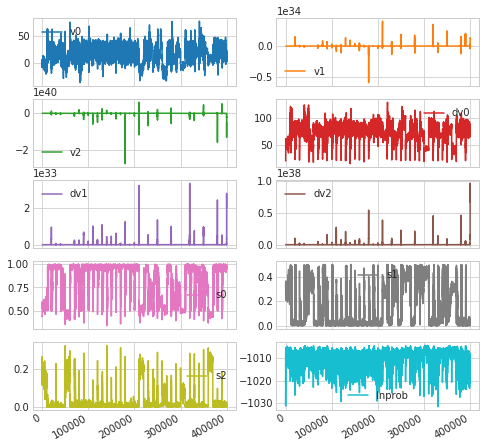

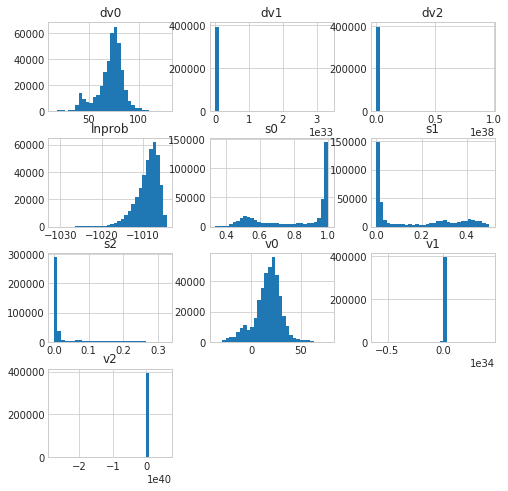

In [98]:
df_cut_res = pd.DataFrame(sampler_cut.flatchain)
df_cut_res = df_cut_res.rename(columns={0:"v0",1:"v1",2:"v2",3:"dv0",4:"dv1",5:"dv2",6:"s0",7:"s1"})
df_cut_res["s2"] = 1-df_cut_res.s0-df_cut_res.s1
df_cut_res["lnprob"] = sampler_cut.flatlnprobability
df_cut_res.plot(subplots=True,figsize=(8,8),layout=(5,2))
df_cut_res.hist(bins=32,figsize=(8,8))
plt.show()

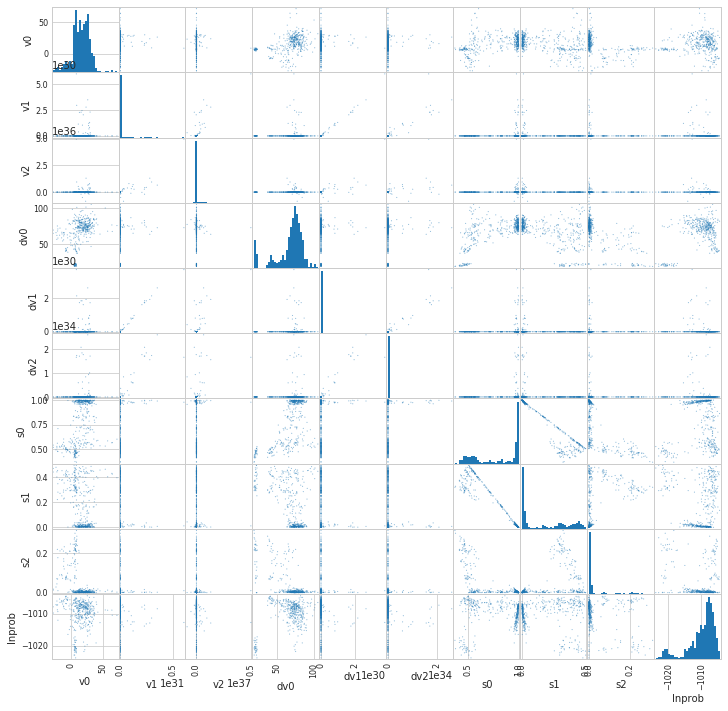

In [67]:
pd.plotting.scatter_matrix(df_cut_res[::1000],figsize=(12,12),hist_kwds={"bins":32},s=5)
plt.show()

In [68]:
df_cut_res.describe(percentiles=[norm.cdf(i) for i in [-2,-1,0,1,2]]) 

,v0,v1,v2,dv0,dv1,dv2,s0,s1,s2,lnprob
count,400000.000000,4.000000e+05,4.000000e+05,400000.000000,4.000000e+05,4.000000e+05,400000.000000,400000.000000,4.000000e+05,400000.000000
mean,16.824105,3.525170e+30,-1.744782e+37,71.715740,6.516620e+30,1.159137e+35,0.811973,0.157794,3.023301e-02,-1008.978837
std,13.804902,9.548293e+31,3.510854e+38,13.383044,6.086939e+31,1.207552e+36,0.204273,0.171201,6.304695e-02,2.752111
min,-36.377941,-5.996204e+33,-2.752985e+40,15.235247,3.159693e-01,3.323882e-01,0.337772,0.000057,4.737572e-07,-1031.522654
2.3%,-15.983291,-2.760092e+02,-4.982006e+37,39.989664,2.927953e+01,2.922714e+01,0.450528,0.001575,9.618200e-05,-1015.909553
15.9%,5.015651,9.359357e+00,-7.103370e+10,59.517415,6.173648e+01,1.178918e+02,0.531694,0.005890,8.268424e-04,-1011.549360
50%,18.630035,8.831211e+01,2.190611e+04,74.261083,1.370961e+02,3.688381e+09,0.950140,0.041954,4.178086e-03,-1008.424189
84.1%,28.498788,1.125696e+23,2.772035e+26,82.572903,9.270906e+23,4.656636e+27,0.991894,0.392008,5.934340e-02,-1006.462525
97.7%,41.578560,1.112313e+31,6.675180e+35,94.622304,3.666396e+31,7.553315e+35,0.997769,0.471222,2.376381e-01,-1005.228137
max,77.632050,4.077611e+33,6.023190e+39,128.088001,3.337141e+33,9.622492e+37,0.999890,0.499199,3.255744e-01,-1004.334928


In [69]:
x_cut = np.linspace(df_bes[isinpoly].Vr.min(),df_bes[isinpoly].Vr.max(),256)
g0_cut = df_cut_res.s0[:,np.newaxis]*norm.pdf(x=x_cut[np.newaxis,:],loc=df_cut_res.v0.values[:,np.newaxis],scale=df_cut_res.dv0.values[:,np.newaxis])
g1_cut = df_cut_res.s1[:,np.newaxis]*norm.pdf(x=x_cut[np.newaxis,:],loc=df_cut_res.v1.values[:,np.newaxis],scale=df_cut_res.dv1.values[:,np.newaxis])
g2_cut = df_cut_res.s2[:,np.newaxis]*norm.pdf(x=x_cut[np.newaxis,:],loc=df_cut_res.v2.values[:,np.newaxis],scale=df_cut_res.dv2.values[:,np.newaxis])
gtot_cut = g0_cut+g1_cut+g2_cut

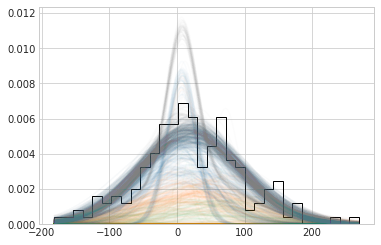

In [94]:
plt.hist(df_bes[isinpoly].Vr,bins=32,histtype="step",density=True,color="black")
[plt.plot(x_cut,g,c="C2",alpha=0.02) for g in g2_cut[::1000]]
[plt.plot(x_cut,g,c="C1",alpha=0.02) for g in g1_cut[::1000]]
[plt.plot(x_cut,g,c="C0",alpha=0.02) for g in g0_cut[::1000]]
[plt.plot(x_cut,g,c="grey",alpha=0.02) for g in gtot_cut[::1000]]
plt.show()

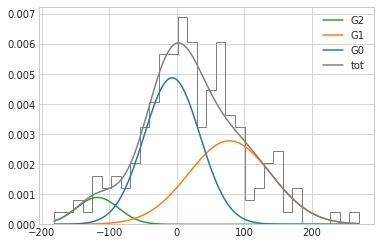

v0          -7.057639
v1          77.898564
v2        -117.660899
dv0         41.387019
dv1         60.814504
dv2         31.151831
s0           0.506147
s1           0.423862
s2           0.069991
lnprob   -1004.334928
Name: 307730, dtype: float64

In [95]:
alpha = 1
plt.hist(df_bes[isinpoly].Vr,bins=32,histtype="step",density=True,color="grey",alpha=alpha)
plt.plot(x_cut,g2_cut[df_cut_res.lnprob.idxmax()],c="C2",alpha=alpha,label="G2")
plt.plot(x_cut,g1_cut[df_cut_res.lnprob.idxmax()],c="C1",alpha=alpha,label="G1")
plt.plot(x_cut,g0_cut[df_cut_res.lnprob.idxmax()],c="C0",alpha=alpha,label="G0")
plt.plot(x_cut,gtot_cut[df_cut_res.lnprob.idxmax()],c="grey",alpha=alpha,label="tot")
plt.legend()
plt.show()
display(df_cut_res.iloc[df_cut_res.lnprob.idxmax()])

In [76]:
df_cut_res.to_csv("result/Becanson_cut.csv")

# Actual Data

In [19]:
cds_walker = ascii.read("data/aj283181t4_mrt.txt",format="cds")
display(cds_walker.info())

df_walker_raw = cds_walker.to_pandas()
rastr = df_walker_raw.apply(lambda data: "{:0>2}h{}m{}s".format(data.RAh,data.RAm,data.RAs),axis=1)
destr = df_walker_raw.apply(lambda data: "{}{:0>2}d{}m{}s".format(data["DE-"],data.DEd,data.DEm,data.DEs),axis=1)
coords = SkyCoord(ra=rastr,dec=destr)
df_walker_raw["RAdeg"],df_walker_raw["DEdeg"] = coords.ra.deg, coords.dec.deg
df_walker = pd.DataFrame(df_walker_raw)
counts_walker = df_walker_raw.Target.value_counts()
# fill weighted value for single counted objects
for key in ["VHel","SigMg"]:
    w_key = "<{}>".format(key) # weghted key
    e_key = "e_"+key
    e_w_key = "e_"+w_key
    df_walker[w_key] = df_walker.apply(func=(lambda line: line[w_key] if counts_walker[line.Target]>1 else line[key]),axis=1)
    df_walker[e_w_key] = df_walker.apply(func=(lambda line: line[e_w_key] if counts_walker[line.Target]>1 else line[e_key]),axis=1)
df_walker = df_walker[np.logical_not(np.isnan(df_walker["<VHel>"]))]
df_walker

<Table masked=True length=1818>
   name    dtype   unit                   description                   n_bad
--------- ------- ------ ---------------------------------------------- -----
   Target    str8               Target identification; Galaxy-ID number     0
    Field    str4                    Field and spectrograph channel (1)     0
      HJD float64      d         Heliocentric Julian Date minus 2450000     0
      RAh   int64      h                Hour of Right Ascension (J2000)     0
      RAm   int64    min              Minute of Right Ascension (J2000)     0
      RAs float64      s              Second of Right Ascension (J2000)     0
      DE-    str1                       Sign of the Declination (J2000)     0
      DEd   int64    deg                  Degree of Declination (J2000)     0
      DEm   int64 arcmin               Arcminute of Declination (J2000)     0
      DEs float64 arcsec               Arcsecond of Declination (J2000)     0
     Vmag float64    mag        

None

,Target,Field,HJD,RAh,RAm,RAs,DE-,DEd,DEm,DEs,...,e_SigFe,SigMg,e_SigMg,PM,<VHel>,e_<VHel>,<SigMg>,e_<SigMg>,RAdeg,DEdeg
0,Scl-0001,20B,3286.629,1,0,46.17,-,33,39,19.6,...,0.02,0.43,0.04,0.998,112.6,1.2,0.56,0.03,15.192375,-33.655444
2,Scl-0002,20B,3286.629,1,0,45.44,-,33,39,59.9,...,0.01,0.39,0.03,1.000,110.2,0.9,0.40,0.03,15.189333,-33.666639
4,Scl-0003,20B,3286.629,1,0,44.46,-,33,41,54.1,...,0.04,0.53,0.06,1.000,116.4,1.9,0.50,0.05,15.185250,-33.698361
6,Scl-0004,20B,3286.629,1,0,46.96,-,33,43,19.9,...,0.02,0.34,0.05,1.000,103.8,0.7,0.34,0.03,15.195667,-33.722194
9,Scl-0005,20B,3286.629,1,0,42.44,-,33,43,26.0,...,0.02,0.33,0.04,1.000,117.7,0.9,0.40,0.03,15.176833,-33.723889
13,Scl-0006,20B,3286.629,1,0,44.88,-,33,43,57.7,...,0.02,0.31,0.05,0.999,93.4,2.2,0.32,0.05,15.187000,-33.732694
15,Scl-0007,20B,3286.629,1,0,42.07,-,33,44,2.7,...,0.04,0.63,0.05,0.991,118.6,2.0,0.63,0.05,15.175292,-33.734083
16,Scl-0008,20B,3286.629,1,0,51.01,-,33,38,20.5,...,0.02,0.63,0.03,0.984,103.6,1.4,0.60,0.03,15.212542,-33.639028
18,Scl-0009,20B,3286.629,1,0,50.99,-,33,40,2.4,...,0.01,0.42,0.03,0.999,95.7,0.8,0.41,0.03,15.212458,-33.667333
20,Scl-0010,20B,3286.629,1,0,49.48,-,33,40,37.8,...,0.02,0.39,0.03,1.000,101.6,1.6,0.41,0.03,15.206167,-33.677167


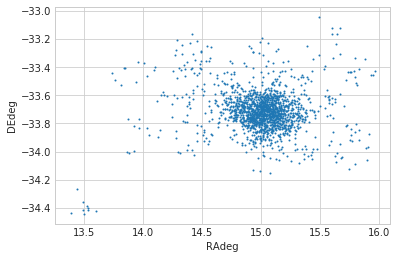

In [20]:
df_walker.plot.scatter("RAdeg","DEdeg",s=1)

In [21]:
from astropy.units import deg
prop_Scl = pd.read_csv("dSph_property.csv",index_col=0).loc["Sculptor"]

sc_walker = SkyCoord(ra=df_walker.RAdeg.values*deg,dec=df_walker.DEdeg.values*deg)
sc_Scl_center = SkyCoord(ra=prop_Scl.RAdeg*deg,dec=prop_Scl.DEdeg*deg)
df_walker["separation_2d"] = sc_walker.separation(sc_Scl_center).deg

(0, 20)

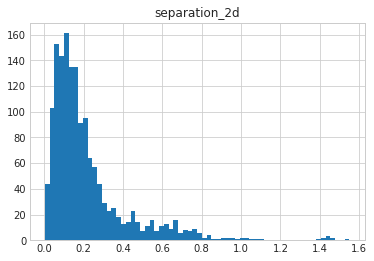

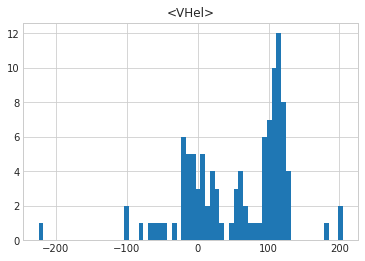

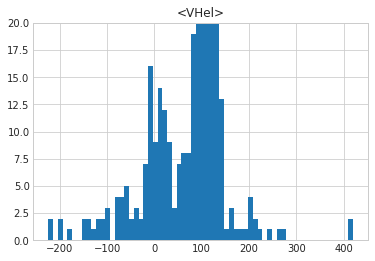

In [22]:
df_walker_cont = df_walker[df_walker.separation_2d>0.6]
df_walker.hist("separation_2d",bins=64)
df_walker_cont.hist("<VHel>",bins=64)
df_walker.hist("<VHel>",bins=64)
plt.ylim((0,20))

In [42]:
%load_ext autoreload
%autoreload 2
import modKI17
import astropy.units as u

sc_obsdata = SkyCoord(
    ra=df_walker.RAdeg.values*u.deg,
    dec=df_walker.DEdeg.values*u.deg,
    radial_velocity=df_walker["<VHel>"].values*u.km/u.s
)
ki17 = modKI17.modKI17(sc_obsdata=sc_obsdata,dsph_name="Sculptor",prior_fname="priorconf_sculptor.csv")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
initialized:
re_pc            200.000000
a                  2.780000
b                  7.780000
g                  0.675000
rhos_Msunpc3       0.008913
rs_pc           9120.108394
R_trunc_pc      2000.000000
dtype: float64
initialized:
Rmax_pc    2325.710013
dtype: float64


In [44]:
ki17.

-inf